In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Database credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))


# Use the connection to extract SQL data
education_df = pd.read_sql_query('SELECT * FROM useducation', con=engine)

# Close the connection
engine.dispose()

In [3]:
print(education_df.isnull().sum()/education_df.isnull().count())

#Fill in missing values using interpolation, based on state
fill_cols = list(education_df.columns.drop(['PRIMARY_KEY', 'STATE', 'YEAR']))
unique_states = education_df['STATE'].unique()

for state in unique_states:
    education_df.loc[education_df["STATE"] == state, fill_cols] = education_df.loc[education_df["STATE"] == state, fill_cols].interpolate()
    
#Percentage of remaining missing values per category:
education_df.isnull().sum()/education_df.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.176273
TOTAL_REVENUE                   0.142091
FEDERAL_REVENUE                 0.142091
STATE_REVENUE                   0.142091
LOCAL_REVENUE                   0.142091
TOTAL_EXPENDITURE               0.142091
INSTRUCTION_EXPENDITURE         0.142091
SUPPORT_SERVICES_EXPENDITURE    0.142091
OTHER_EXPENDITURE               0.176273
CAPITAL_OUTLAY_EXPENDITURE      0.142091
GRADES_PK_G                     0.115952
GRADES_KG_G                     0.088472
GRADES_4_G                      0.087802
GRADES_8_G                      0.087802
GRADES_12_G                     0.087802
GRADES_1_8_G                    0.087802
GRADES_9_12_G                   0.087802
GRADES_ALL_G                    0.115952
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.141421
TOTAL_REVENUE                   0.107909
FEDERAL_REVENUE                 0.107909
STATE_REVENUE                   0.107909
LOCAL_REVENUE                   0.107909
TOTAL_EXPENDITURE               0.107909
INSTRUCTION_EXPENDITURE         0.107909
SUPPORT_SERVICES_EXPENDITURE    0.107909
OTHER_EXPENDITURE               0.141421
CAPITAL_OUTLAY_EXPENDITURE      0.107909
GRADES_PK_G                     0.032842
GRADES_KG_G                     0.004692
GRADES_4_G                      0.004692
GRADES_8_G                      0.004692
GRADES_12_G                     0.004692
GRADES_1_8_G                    0.004692
GRADES_9_12_G                   0.004692
GRADES_ALL_G                    0.032842
AVG_MATH_4_SCORE                0.144102
AVG_MATH_8_SCORE                0.146783
AVG_READING_4_SCORE             0.162198
AVG_READING_8_SC

### 1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

In [26]:
weighted_avgscore = (((education_df['GRADES_4_G'].interpolate(method='linear'))*(education_df['AVG_MATH_4_SCORE'].interpolate(method='linear')+education_df['AVG_READING_4_SCORE'].interpolate(method='linear'))) + ((education_df['GRADES_8_G'].interpolate(method='linear'))*(education_df['AVG_MATH_8_SCORE'].interpolate(method='linear')+education_df['AVG_READING_8_SCORE'].interpolate(method='linear'))))/(2*(education_df['GRADES_8_G'].interpolate(method='linear')+education_df['GRADES_4_G'].interpolate(method='linear')))

education_df['AVG_WEIGHTED_SCORES'] = weighted_avgscore

weighted_avgscore

0              NaN
1       232.851618
2       235.639070
3       235.441283
4       230.756386
5       241.797898
6       245.559478
7       236.784089
8       215.523511
9       233.291621
10      235.028058
11      231.536438
12      241.642042
13      242.426591
14      243.447298
15      249.222715
16      242.618470
17      237.711179
18      226.900838
19      249.337041
20      236.682668
21      244.984537
22      241.897239
23      247.078298
24      227.203607
25      242.416498
26      244.769527
27      245.630165
28      245.616604
29      246.556758
           ...    
1462    255.438803
1463    253.984249
1464    251.798676
1465    242.666326
1466    250.682887
1467    253.368293
1468    262.452134
1469    252.923462
1470    257.810298
1471    247.304408
1472    249.505607
1473    252.993607
1474    255.993860
1475    247.378895
1476    257.309000
1477    261.773192
1478    245.074322
1479    248.580997
1480    252.680110
1481    253.242575
1482    255.054666
1483    249.

### 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [35]:
print('\nCorrelations Between AVG_WEIGHTED_SCORES and EXPENDITURES: \n')
print(education_df[['AVG_WEIGHTED_SCORES', 'INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']].corr()['AVG_WEIGHTED_SCORES'])


Correlations Between AVG_WEIGHTED_SCORES and EXPENDITURES: 

AVG_WEIGHTED_SCORES             1.000000
INSTRUCTION_EXPENDITURE         0.148275
SUPPORT_SERVICES_EXPENDITURE    0.148728
OTHER_EXPENDITURE               0.068050
CAPITAL_OUTLAY_EXPENDITURE      0.073822
Name: AVG_WEIGHTED_SCORES, dtype: float64


SUPPORT_SERVICES_EXPENDITURE has a slightly higher correlation (14.9%) with AVG_WEIGHTED_SCORES when compared to all other subgroups of expenditures.

### 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

Covariance Matrix:
 [[1.00078125 0.14008722 0.13994776 0.06810355 0.0622449 ]
 [0.14008722 1.00078125 0.97677452 0.90881349 0.89428808]
 [0.13994776 0.97677452 1.00078125 0.95404173 0.91626872]
 [0.06810355 0.90881349 0.95404173 1.00078125 0.92148208]
 [0.0622449  0.89428808 0.91626872 0.92148208 1.00078125]]
Eigenvector 1: 
[0.07329001 0.49868715 0.50749684 0.49775116 0.49054097]
Eigenvalue 1: 3.8021866904066077
----------------------------------------
Eigenvector 2: 
[ 0.99383433  0.00712752  0.0016351  -0.07488005 -0.08144214]
Eigenvalue 2: 0.9917841243648367
----------------------------------------
Eigenvector 3: 
[-0.01910902 -0.51820657  0.7947269  -0.3143367   0.026427  ]
Eigenvalue 3: 0.013622843878504137
----------------------------------------
Eigenvector 4: 
[ 0.07825724 -0.58410022 -0.3232213   0.20089829  0.71265041]
Eigenvalue 4: 0.11883951625641415
----------------------------------------
Eigenvector 5: 
[-0.02079766  0.37623026 -0.07988388 -0.77940303  0.49413332]
Eigen

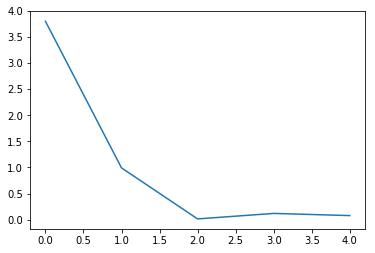

[3.80218669 0.99178412 0.01362284 0.11883952 0.07747308]


In [37]:
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

education2 = education_df[['AVG_WEIGHTED_SCORES', 'INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']].copy()
education2 = education2.dropna()
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(education2)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)


# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)



The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.75984371]


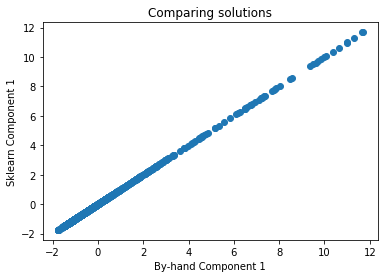

In [38]:
sklearn_pca = PCA(n_components=1)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

As the above plots and printouts show, the first Component can explain approximately 76% of the total variance in our dataframe.

### 4. What is the correlation between the overall score variable and the 1st principal component?

In [45]:
comparison_df = pd.DataFrame()
comparison_df['AVG_WEIGHTED_SCORES'] = education2['AVG_WEIGHTED_SCORES'].copy()
comparison_df['First Component'] = Y_sklearn

comparison_df.corr()

,AVG_WEIGHTED_SCORES,First Component
AVG_WEIGHTED_SCORES,1.000000,0.142854
First Component,0.142854,1.000000


The correlation between the first principal component and the overall score variable is 14.3%.

### 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

Even though two of the expenditure variables show a higher correlation to the new feature compared to the first principal component, I would still use PCA instead of the expenditure variables, because it's able to compile all of the information of 4 expenditure variables into one component, which is still at a comparable level of correlation.